# Imports

In [33]:
# Librairies
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import pickle
import time
from sklearn.model_selection import GridSearchCV


In [34]:

df = pd.read_csv('bus_trafic_clean.csv')
df = df.astype({"horodatage": "datetime64",
                "horodatage_maj": "datetime64",
                "Heure_estimee_de_passage_a_L_arret": "datetime64",
                "date_heure": "datetime64",
                "date": "datetime64",
                "date_heure": "datetime64",
                "numero_de_parc_du_vehicule": "category"
                })

## Préparation des données

In [ ]:
#Sélection des variables
df_RLM = df[['date',
             'ecart_horaire_en_secondes',
             'nom_de_la_ligne', 
             'etat_SAE_du_vehicule',
             'month',
             'day',
             'jour_semaine',
             'OPINION']]

# transfo saisonnalité 
df_RLM['day'] = (df_RLM['day']) * (1/31)
df_RLM['month'] = (df_RLM['month'] - 7) * (1/5)
Days = {'Lundi': 1/7, 'Mardi': 2/7, 'Mercredi': 3/7, 'Jeudi': 4/7, 'Vendredi': 5/7, 'Samedi': 6/7, 'Dimanche': 7/7}
df_RLM['jour_semaine'] = df_RLM['jour_semaine'].map(Days)

# différence en secondes entre l'heure estimée de passage et l'horodatage
df_RLM['diff_estimee'] = (
    df['Heure_estimee_de_passage_a_L_arret'] - df['horodatage']).dt.total_seconds() / 60

# différence en secondes entre l'horodatage et sa mise à jour
df_RLM['diff_maj'] = -(
    df['horodatage_maj'] - df['horodatage']).dt.total_seconds() / 60

On veut prédire la qualité du trafic le jour suivant, cela implique de grouper nos données par jour (saisonnalité journalière) cette opération est destructrice puisqu'elle ne permet pas reconstituer les données d'origine.

Notre modèle doit pouvoir prédire le trafic du jour suivant en se basant sur les données de la veille. Nous pourrions inclure les données des jours précédents avec un modèle *LSTM* qui est parfaitement adapté à des données temporelles. Mais nous n'avons pas assez de données pour un modèle LSTM (uniquement 128 jours d'observations).

Revenons sur la consigne, nous devons prédire "la qualité du trafic le jour suivant". 
Plaçons-nous dans la vision d'un utilisateur du réseau de tram et de bus, il souhaite savoir si le trafic sera bon ou mauvais le lendemain. 
Généralement, un utilisateur utilise toujours la même ligne de tram ou de bus, qu'il utilise pour faire l'aller puis le retour. Nous réaliserons donc des **prévisions par lignes de bus/tram**, puisque qu'une prédiction globale n'a que peu d'intérêt pour l'utilisateur et qu'une prédiction plus précise nécessite plus de données.

Pour symboliser la qualité du trafic, nous allons utiliser la variable "ecart_horaire_en_secondes" qui est une variable numérique. Cela implique d'utiliser un modèle de régression.
Pour pouvoir agréger ces données par jours, nous choisissons l'agrégation de somme, cela permettra de mettre en avant la variabilité entre les lignes. Puisque plus une ligne est utilisée, plus le nombre de bus à son service est haut et donc plus de requêtes qui la concerne sont effectuées. Ainsi si une ligne est très utilisée et a de nombreux retards alors sa somme des écarts sera très importante. Cela permettra de pénaliser à hauteur de la fréquentation de la ligne. (Selon l’hypothèse bcp de voyageurs => bcp de bus en activité sur cette ligne)  

Résumé : en entrée nous aurons les données agrégées de la veille en globale et les dernières données agrégées par ligne, ainsi que la ligne que nous souhaitons prédire, en sortie nous aurons la somme des écarts horaires de la ligne que nous souhaitons prédire.


In [ ]:
# Si le bus/tram est arrivé en avance, on considère que l'écart horaire est nul 
# => éviter que les bus en avance annule ceux en retards lors de l'opération de somme
df_RLM['ecart_horaire_en_secondes'] = df_RLM['ecart_horaire_en_secondes'].apply(lambda x: 0 if x < 0 else x)

# Aggrégation par jour et par ligne
df_group = df_RLM.groupby(['date','nom_de_la_ligne']).agg(
    {'ecart_horaire_en_secondes' : 'sum',
     'diff_estimee' : 'sum',
     'diff_maj' : 'sum',
     'month' : 'first',
     'day' : 'first',
     'jour_semaine' : 'first',
     'OPINION' : 'first'
    }).merge((df_RLM
  .groupby(["date",'nom_de_la_ligne', 'etat_SAE_du_vehicule'])
  .size()
  .unstack('etat_SAE_du_vehicule', fill_value=0)
  .add_prefix("nombre_etat_")
), on=['date','nom_de_la_ligne'], how='left')
    
    		
# Les valeurs d'écarts prochaines pour chaque ligne et la date de celles-ci
df_group[['next_ecart','month','day','jour_semaine']] = df_group.groupby('nom_de_la_ligne')[['ecart_horaire_en_secondes','month','day','jour_semaine']].shift()
df_group.dropna(inplace=True)       
  
df_group.reset_index(inplace=True, level=['nom_de_la_ligne'])
  
#Ajout données globales de la veille  
df_group.merge(
  df_RLM.groupby('date').agg({
    'ecart_horaire_en_secondes' : 'sum',
     'diff_estimee' : 'sum',
     'diff_maj' : 'sum',  }).rename(columns=
                  {'ecart_horaire_en_secondes': 'ecart_horaire_en_secondes_global',
                   'diff_estimee' : 'diff_estimee_global',
                   'diff_maj' : 'diff_maj_global'}), on=['date'], how='left')

In [37]:
df_group.groupby(['date']).agg(
    {'nom_de_la_ligne' : "nunique"}).describe()

,nom_de_la_ligne
count,127.000000
mean,28.488189
std,9.579961
min,1.000000
25%,30.000000
50%,32.000000
75%,34.000000
max,36.000000


On remarque que certains jours, il n'y a que très peu de lignes de bus actives. et certaines lignes de bus n'ont que très peu de données.
On pourrait limiter notre prédiction aux lignes les plus actives.

lignes_keep = df_RLM['nom_de_la_ligne'].value_counts().index[:15]

df_group = df_group[df_group['nom_de_la_ligne'].isin(lignes_keep)]

Mais cela pénaliserait les utilisateurs de petite ligne, pour régler cela nous avons réaliser le shift sur les dates en plus de la valeur à prédire. Cela permet de récupérer l'information de saisonnalité perdu lorsqu'une ligne n'est pas active chaque jour.

In [38]:
# One Hot Encoding
df_group = pd.get_dummies(df_group, columns=['OPINION','nom_de_la_ligne'])
df_group.shape

(3618, 69)

In [39]:
df_group.head()

,ecart_horaire_en_secondes,diff_estimee,diff_maj,month,day,jour_semaine,nombre_etat_DEV,nombre_etat_DEVP,nombre_etat_GARE,nombre_etat_HC,...,nom_de_la_ligne_SOIR MAIRIE PONTS CE <> AVRILLE,nom_de_la_ligne_SOIR TRELAZE <> LORRAINE,nom_de_la_ligne_SOUCELLES PELLOUAILLES <> GARE,nom_de_la_ligne_SOULAINES <> GARE,nom_de_la_ligne_ST CLEMENT St LAMBERT <> GARE,nom_de_la_ligne_ST LEGER St LAMBERT <> GARE,nom_de_la_ligne_ST LEZIN SORGES <> SCHWEITZER,nom_de_la_ligne_ST MARTIN St JEAN <> GARE,nom_de_la_ligne_ST MATHURIN <> GARE,nom_de_la_ligne_ST SYLVAIN BANCHAIS <>TRELAZE
date,,,,,,,,,,,,,,,,,,,,,
2019-08-06,78928.0,-4483.016667,4.600000,0.2,0.16129,0.142857,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,16712.0,-2698.450000,2.383333,0.2,0.16129,0.142857,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,41219.0,-4572.566667,3.516667,0.2,0.16129,0.142857,3,21,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,82449.0,-5539.166667,3.233333,0.2,0.16129,0.142857,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,25609.0,-3205.250000,2.733333,0.2,0.16129,0.142857,6,42,0,0,...,0,0,0,0,0,0,0,0,0,0


**Explication du choix de la Régression**

L'utilisation de la classification ne permet pas de quantifier, or le temps se doit d'être quantifiable, ex : "votre avion a un retard modéré" ne permet pas de quantification et donc pas de prise de décision sur le choix d'un autre mode de transport.

Utilisé la classification pour notre problématique desservirait l'objectif d'un retard perçu moindre, et ce par la perte de variabilité engendré.

On peut néanmoins songer à un algorithme de CAH pour labelliser les retards prévus.

# Modèle Prophet

Dans un premier temps, essayons de prédire la variable expliqué avec uniquement la variable date. 
Pour cela, nous allons utiliser le modèle Prophet de Facebook. Ce modèle est basé sur la décomposition de la série temporelle en trois composantes : tendance, saisonnalité et bruit. Il est donc particulièrement adapté à la prédiction de séries temporelles à condition qu'il y ait un lien entre la variable à expliqué et la date.

In [40]:
m = Prophet()

df_prophet = df_group['next_ecart'].reset_index()
#df_prophet = df_prophet.drop_duplicates(subset='date', keep='first')

df_prophet = df_prophet.rename(
    columns={'date': 'ds', 'next_ecart': 'y'})

In [ ]:
train , test = train_test_split(df_prophet, test_size=0.2, random_state=0)
m.fit(train)

Nous allons utilisés comme indicateurs de performances : R², MSE, MAE et MAP.
Il est important de pouvoir évaluer nos différents modèles de prédiction par rapport à une prédiction naive. 

##### Prédiction par la moyenne

In [42]:
mean_pred = pd.Series([train['y'].mean()] * len(test))
y = test['y']

print(
    "r2_score : ", r2_score(y, mean_pred))
print(
    'mean_squared_error : ', mean_squared_error(y, mean_pred))
print(
    'mean_absolute_error : ', mean_absolute_error(y, mean_pred))
print(
    'mean_absolute_percentage_error', mean_absolute_percentage_error(y, mean_pred))

r2_score :  -0.003361168689904215
mean_squared_error :  1662459693.4053388
mean_absolute_error :  31396.342259847956
mean_absolute_percentage_error 8.036356941654388e+17


##### Prédiction par modèle Prophet

In [43]:
predictions = m.predict(test[['ds']])
predictions = predictions['yhat']
y = test['y']

print(
    "r2_score : ", r2_score(y, predictions))
print(
    'mean_squared_error : ', mean_squared_error(y, predictions))
print(
    'mean_absolute_error : ', mean_absolute_error(y, predictions))
print(
    'mean_absolute_percentage_error', mean_absolute_percentage_error(y, predictions))


r2_score :  -0.07339777681319881
mean_squared_error :  1778502691.3816607
mean_absolute_error :  31725.029691098855
mean_absolute_percentage_error 6.64901060380449e+17


En comparant les résultats de la prédiction par la moyenne et par le modèle Prophet, on peut voir que le modèle Prophet a des performances excécrables. 

Cela est dû au fait que l'horodatage ne contient peu ou pas d'information sur la variable à expliqué ou que la connaissance n'est disponible que par combinaisons avec d'autres variables.

Nous pourions utiliser le modèle Prophet pour expliquer la saisonnalité et la tendance, puis entrainer des modèles de régression sur les résidus. Cependant, il s'agit d'un modèle inutilement complexe pour le nombre d'observations limités que nous avons.

Continuons dans les modèles explicables avec une régression linéaire multiple qui implique un lien linéaire entre la variable à expliqué et les variables explicatives.

# Modèle de Régression linéaire Multiple

In [44]:
Xtrain , Xtest , Ytrain , Ytest = train_test_split(df_group.drop('next_ecart', axis=1), df_group['next_ecart'], test_size = 0.2, random_state = 0)

collones = df_group.columns.drop('next_ecart')

In [45]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit(Xtrain)
Xtrain_poly = poly.transform(Xtrain)
Xtest_poly = poly.transform(Xtest)
Xtrain_poly.shape

(2894, 2347)

Nous avons essayer de tirer les liens polynomiales entre nos variables et la variable à expliquer par combinaisons de nos variables entre elles et avec elles même. Cependant, il en ressort 2347 collones à cause de nos variables qualitative mis en one-hot-encoding. 
Ce qui détruirait l'explicabilité, alors que cela est l'objectif d'avoir un modèle simple.

In [46]:
#On remets les noms de collones
Xtrain = pd.DataFrame(Xtrain, columns= collones)
Xtest = pd.DataFrame(Xtest, columns= collones)

Nous avons en entrée la matrix Xtrain et un vecteur Ytrain pour chaque variable $X[:, i]$ calculons $\rho_i = \frac{(X[:, i] - mean(X[:, i])) * (y - mean(y))}{std(X[:, i]) * std(y)} $ auquel on associe la F-statistique $F_i = \frac{\rho_i^2}{1 - \rho_i^2}*(n-2)$

In [47]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

# On affiche les 10 variables les plus liés à la variable à expliquer
select = SelectKBest(f_regression, k=10)
select.fit(Xtrain, Ytrain)

features = zip(list(Xtrain.columns[select.get_support(indices=True)]), list(
    select.scores_[select.get_support(indices=True)]))
print('Meilleures variables avec p-value: %s' % list(features))




Meilleures variables avec p-value: [('ecart_horaire_en_secondes', 6819.687859153964), ('diff_estimee', 798.8279199674803), ('nombre_etat_DEV', 318.9731913132953), ('nombre_etat_DEVP', 786.0303571809147), ('nombre_etat_HLP', 785.5448662085956), ('nombre_etat_HLPR', 836.4030830260609), ('nombre_etat_LIGN', 6295.021909637806), ('nombre_etat_TARR', 1254.7578145248142), ('nombre_etat_TDEP', 2262.684739320788), ('nom_de_la_ligne_BELLE BEILLE <> MONPLAISIR', 943.8420765244354)]


In [48]:
#rename 
X_train = Xtrain 
X_test = Xtest 
y_train = Ytrain 
y_test = Ytest

# Fit et évaluation de différents modèles

In [49]:
df_result = pd.DataFrame(columns=["model", "CV", "R2", "MSE", "MAE", "MAPE", "Temps d'execution"])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

time_start = time.time()

lr= LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["lr", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

<AxesSubplot: title={'center': 'Coefficients de la régression linéaire'}, xlabel='Coefficient'>

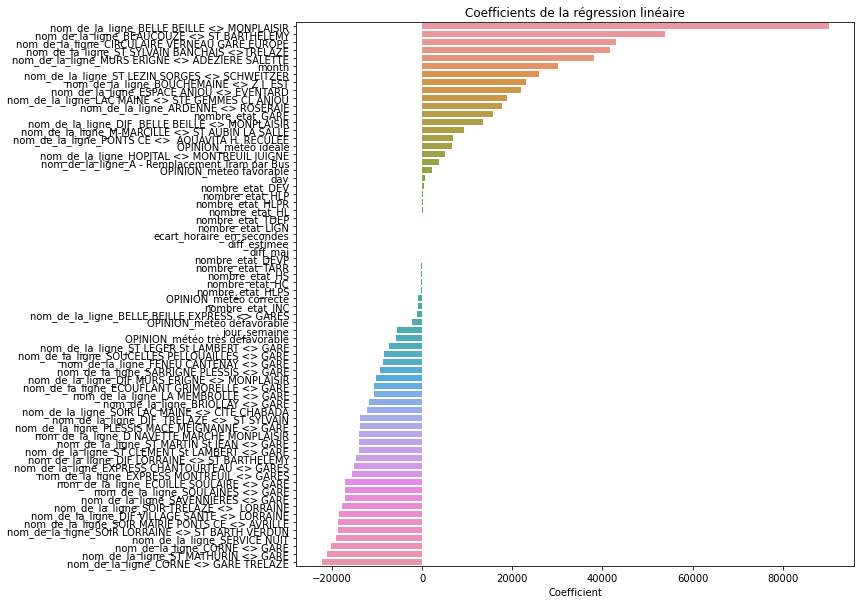

In [51]:
# Coefficients de la régression linéaire
coef_value = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

import seaborn as sns
fig = sns.barplot(x='Coefficient', y=coef_value.index, data=coef_value)
fig.set_title('Coefficients de la régression linéaire')
fig.figure.set_size_inches(10, 10)
fig

Grâce à l'explicabilité permise par la régression linéaire, on observe aisément que c'est bien le nom de la ligne qui influe le plus sur la prédiction de ce modèle. 

In [ ]:
time_start = time.time()

param_grid = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, refit = True, verbose = 3, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["lr_grid", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
from sklearn.linear_model import Ridge

time_start = time.time()

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["ridge", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
time_start = time.time()

param_grid = {'alpha': [0.1, 1, 10, 100, 1000], 'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid = GridSearchCV(Ridge(), param_grid, refit = True, verbose = 3, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["ridge_grid", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

time_start = time.time()

clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["RandomForestRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Pkl_Filename = "Model_1_full_regressor.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [ ]:
time_start = time.time()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["RandomForestRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
from sklearn.linear_model import SGDRegressor

time_start = time.time()

sgdr = SGDRegressor().fit(X_train, y_train)

y_pred = sgdr.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["SGDRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
# grid search SGDRegressor
from sklearn.model_selection import GridSearchCV

time_start = time.time()

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1, 10, 100]
}

sgdr = SGDRegressor()
grid_search = GridSearchCV(estimator = sgdr, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)
    
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["SGDRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
from sklearn.neural_network import MLPRegressor

time_start = time.time()

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["MLPRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
time_start = time.time()

param_grid = {'hidden_layer_sizes': [(100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)],
                'max_iter': [1000, 2000, 3000],
                'random_state': [42]}
grid = GridSearchCV(MLPRegressor(), param_grid, refit=True, verbose=3, n_jobs=-1)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["MLPRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [ ]:
mean_pred = pd.Series([y_train.mean()] * len(y_test))

tab = ["Mean", "false", r2_score(y, mean_pred), mean_squared_error(y, mean_pred), mean_absolute_error(y, mean_pred), mean_absolute_percentage_error(y, mean_pred), 0]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

In [62]:
df_result["Temps d'execution"] = df_result["Temps d'execution"].apply(lambda x: round(x, 2))
df_result.to_csv("result.csv", index=False)

In [63]:
df_result

,model,CV,R2,MSE,MAE,MAPE,Temps d'execution
0,lr,false,7.821788e-01,3.609059e+08,1.188271e+04,2.269409e+17,0.01
1,lr_grid,true,7.821706e-01,3.609196e+08,1.188295e+04,2.266480e+17,0.30
2,ridge,false,7.809682e-01,3.629118e+08,1.179558e+04,1.890521e+17,0.01
3,ridge_grid,true,7.821015e-01,3.610339e+08,1.187371e+04,2.223251e+17,1.07
4,RandomForestRegressor,false,8.978852e-01,1.691930e+08,6.953418e+03,6.254150e+16,1.43
5,RandomForestRegressor,true,8.049467e-01,3.231820e+08,1.053980e+04,9.809360e+16,97.55
6,SGDRegressor,false,-6.589353e+25,1.091784e+35,1.980848e+17,4.914564e+29,0.03
7,SGDRegressor,true,7.012663e-01,4.949690e+08,1.117295e+04,6.013572e+16,51.48
8,MLPRegressor,false,7.107269e-01,4.792940e+08,1.152466e+04,6.097233e+16,3.64
9,MLPRegressor,true,6.620990e-01,5.598651e+08,1.302454e+04,7.186315e+16,31.38
